In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_bvp
import os
import sys

# Asymmetric case
## Concentration

**Equation** :
$$\chi_s^2 c''(x) - c(x) + c^a = 0$$

**Boundary conditions** :
$$c(0) = \delta C_1, c(1) = \delta C_2$$

**Parameters** : $\chi_s$ and $c^a$

In [2]:
# Real function

def c_analytical_asymmetric(x, chis, C1, C2, ca=0) :
    c1 = (C1 - ca) * np.sinh((x-1.)/chis) / np.sinh(1./chis)
    c2 = (C2 - ca) * np.sinh((x)/chis) / np.sinh(1./chis)
    return ca - c1 + c2


In [3]:
# Boundary conditions
dC1, dC2 = 1., 2.

# Parameters
chis, ca = 5e-1, 0.

In [4]:
def fun_concentration_asymmetric(x, c) :
    global chis, ca
    return np.vstack((c[1], (c[0]-ca)/chis**2))

def bc_concentration_asymmetric(ca, cb) :
    return np.array([ca[0]-dC1, cb[0]-dC2])

In [5]:
x = np.linspace(0., 1., 20)
c = np.ones((2, x.size))
c[0, 0] = dC1
c[0, -1] = dC2


   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.09e-05       2.22e-16          20              0       
Solved in 1 iterations, number of nodes 20. 
Maximum relative residual: 1.09e-05 
Maximum boundary residual: 2.22e-16


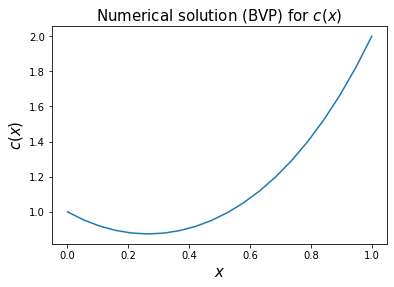

In [6]:
sol = solve_bvp(fun_concentration_asymmetric, bc_concentration_asymmetric, x, c, verbose=2, max_nodes=7000)


plt.plot(sol.x, sol.y[0])
plt.xlabel(r'$x$', fontsize=15)
plt.ylabel(r'$c(x)$', fontsize=15)
plt.title(r'Numerical solution (BVP) for $c(x)$', fontsize=15)
plt.show()

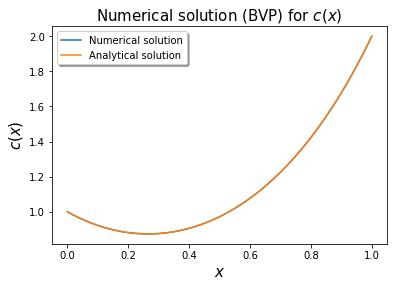

In [7]:
x_plot = np.linspace(0, 1., 1001)
c_plot = sol.sol(x_plot)[0]
dc_plot = sol.sol(x_plot)[1]


plt.title(r'Numerical solution (BVP) for $c(x)$', fontsize=15)
plt.plot(x_plot, c_plot, label='Numerical solution')

plt.plot(x_plot, c_analytical_asymmetric(x_plot, chis, dC1, dC2, ca), label = 'Analytical solution')
plt.legend(shadow=True)
plt.xlabel(r'$x$', fontsize=15)
plt.ylabel(r'$c(x)$', fontsize=15)
plt.show()

# Pressure

**Equation**

$$\begin{cases}p''(x) &= \frac{1}{\chi_v^2} \left[p(x) - c(x)\right] \\
c''(x) &= \frac{1}{\chi_s^2} \left[ c(x) - c^a \right] \end{cases}$$

**Boundary Conditions**
$$c(0) = \delta C_1, c(1) = \delta C_2$$
$$p(0) = P_1, p(1) = P_2$$

**Parameters :** $\chi_v$, $\chi_s$, $c^a$


In [8]:
def p_analytical_asymmetric(x, chiv, P1, P2, chis, C1, C2, ca=0) :
    
    p1 = P1 * np.sinh((x-1.)/chiv) / np.sinh(1./chiv)
    p2 = P2 * np.sinh(x/chiv) / np.sinh(1./chiv)

    lambda_0 = lam_asymmetric(0, chiv, chis, C1, C2, ca) * np.sinh((x-1.)/chiv) / np.sinh(1./chiv)
    mu_0 = mu_asymmetric(0, chiv, chis, C1, C2, ca) * np.sinh((x-1.)/chiv) / np.sinh(1./chiv)
    #print lambda_0, mu_0
    
    lambda_x = lam_asymmetric(x, chiv, chis, C1, C2, ca) * np.exp(x / chiv)
    mu_x = mu_asymmetric(x, chiv, chis, C1, C2, ca) * np.exp(-x / chiv)
    return - p1 + p2 + lambda_x + mu_x + lambda_0 + mu_0

def I_0_minus_asymmetric(x, chiv, chis) :
    if chiv - chis == 0. :
        return 0.5*(x-1) + 0.25*chiv*(np.exp(-2*x/chiv) - np.exp(-2./chiv))
    return (-chiv*np.exp(-x/chiv)*(np.sinh(x/chis)+(chiv/chis)*np.cosh(x/chis)) + chiv*np.exp(-1./chiv)*(np.sinh(1./chis) + (chiv/chis)*np.cosh(1./chis)))/(1. - (chiv/chis)**2)

def I_1_minus_asymmetric(x, chiv, chis) :
    if chiv - chis == 0 :
        return 0.5*(x-1.)*np.exp(-1./chiv) + 0.25*chiv*(np.exp((-2.*x+1)/chiv) - np.exp(-1./chiv))
    return (-chiv*np.exp(-x/chiv)*(np.sinh((x-1.)/chis) + (chiv/chis)*np.cosh((x-1.)/chis)) + (chiv*chiv/chis)*np.exp(-1/chiv)) /(1. - (chiv/chis)**2)

def I_0_plus_asymmetric(x, chiv, chis) :
    if chiv - chis == 0 :
        return 0.25 * chiv * (np.exp(2.*x/chiv) - np.exp(2./chiv)) - 0.5*(x-1.)
    return (chiv*np.exp(x/chiv)*(np.sinh(x/chis)-(chiv/chis)*np.cosh(x/chis)) - chiv*np.exp(1/chiv)*(np.sinh(1./chis) - (chiv/chis)*np.cosh(1./chis)))/(1. - (chiv/chis)**2)

def I_1_plus_asymmetric(x, chiv, chis) :
    if chiv - chis == 0 :
        return 0.25 * chiv * (np.exp((2.*x-1)/chiv) - np.exp(1./chiv)) - 0.5*(x-1.)*np.exp(1./chiv)
    return (chiv*np.exp(x/chiv)*(np.sinh((x-1.)/chis) - (chiv/chis)*np.cosh((x-1.)/chis)) + (chiv*chiv/chis)*np.exp(1/chiv)) /(1. - (chiv/chis)**2)

def lam_asymmetric(x, chiv, chis, C1, C2, ca=0) :
    la = 0.5*ca * (np.exp(-x/chiv) - np.exp(-1./chiv))
    l1 = (C1-ca) * I_1_minus_asymmetric(x, chiv, chis) / (2*chiv*np.sinh(1./chis))
    l2 = (C2-ca) * I_0_minus_asymmetric(x, chiv, chis) / (2*chiv*np.sinh(1./chis))
    return la + l1 - l2
    #return 0.

def mu_asymmetric(x, chiv, chis, C1, C2, ca=0) :
    ma = 0.5*ca * (np.exp(x/chiv) - np.exp(1./chiv))
    m1 = (C1-ca) * I_1_plus_asymmetric(x, chiv, chis) / (2*chiv*np.sinh(1./chis))
    m2 = (C2-ca) * I_0_plus_asymmetric(x, chiv, chis) / (2*chiv*np.sinh(1./chis))
    return ma - m1 + m2
    #return 0.


In [9]:
# Boundary conditions
dC1, dC2 = 0., 5.
P1, P2 = 1., 5.

# Parameters
chiv, chis, ca = 5e-1, 5e-1, 0.

In [10]:
def fun_syst_asymmetric(x, y) :
    global chiv, chis, ca
    return np.vstack((y[1], (y[0]-ca)/chis**2, y[3], (y[2]-y[0])/chiv**2))

def bc_syst_asymmetric(ya, yb) :
    return np.array([ya[0]-dC1, yb[0]-dC2, ya[2]-P1, yb[2]-P2])

In [11]:
x = np.linspace(0., 1., 101)
y = np.zeros((4, x.size))

# y[0, :] = c(x) ; y[1, :] = c'(x) ; y[2, :] = p(x) ; y[3, :] = p'(x)

y[0, 0], y[0, -1] = dC1, dC2

y[2, 0], y[2, -1] = P1, P2


   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.28e-06       8.88e-16          101             0       
Solved in 1 iterations, number of nodes 101. 
Maximum relative residual: 1.28e-06 
Maximum boundary residual: 8.88e-16


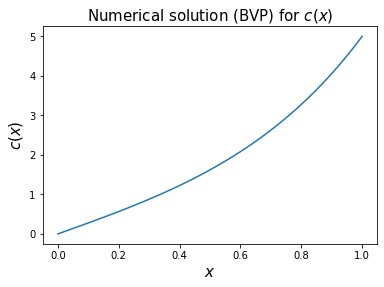

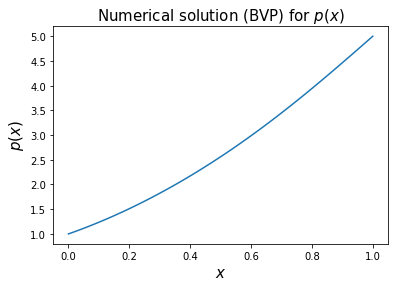

In [12]:
sol = solve_bvp(fun_syst_asymmetric, bc_syst_asymmetric, x, y, verbose=2)

plt.plot(sol.x, sol.y[0])
plt.xlabel(r'$x$', fontsize=15)
plt.ylabel(r'$c(x)$', fontsize=15)
plt.title(r'Numerical solution (BVP) for $c(x)$', fontsize=15)
plt.show()

plt.plot(sol.x, sol.y[2])
plt.xlabel(r'$x$', fontsize=15)
plt.ylabel(r'$p(x)$', fontsize=15)
plt.title(r'Numerical solution (BVP) for $p(x)$', fontsize=15)
plt.show()

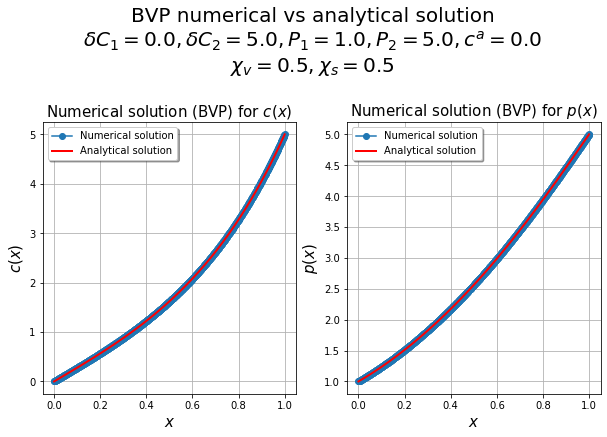

In [13]:
x_plot = np.linspace(0, 1., 1001)
c_plot = sol.sol(x_plot)[0]
p_plot = sol.sol(x_plot)[2]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plt.suptitle('BVP numerical vs analytical solution\n$\delta C_1='+str(dC1)+', \delta C_2='+str(dC2)+', P_1='+str(P1)+', P_2='+str(P2)+', c^a='+str(ca)+'$\n$\chi_v='+str(chiv)+', \chi_s='+str(chis)+'$', y=1.2, fontsize=20)

ax[0].set_title(r'Numerical solution (BVP) for $c(x)$', fontsize=15)
ax[0].plot(x_plot, c_plot, label='Numerical solution', color = 'C0', marker='o')
ax[0].plot(x_plot, c_analytical_asymmetric(x_plot, chis, dC1, dC2, ca), label = 'Analytical solution', linewidth=2, color = 'r')
ax[0].legend(shadow=True)
ax[0].set_xlabel(r'$x$', fontsize=15)
ax[0].set_ylabel(r'$c(x)$', fontsize=15)
ax[0].grid()

ax[1].set_title(r'Numerical solution (BVP) for $p(x)$', fontsize=15)
ax[1].plot(x_plot, p_plot, label='Numerical solution', color = 'C0', marker='o')
ax[1].plot(x_plot, p_analytical_asymmetric(x_plot, chiv, P1, P2, chis, dC1, dC2, ca), label = 'Analytical solution', linewidth=2, color = 'r')
ax[1].legend(shadow=True)
ax[1].set_xlabel(r'$x$', fontsize=15)
ax[1].set_ylabel(r'$p(x)$', fontsize=15)
ax[1].grid()

plt.show()


In [14]:
def plot_cleft_sol_asymmetric(chis, chiv, dC1, dC2, P1, P2, ca) :
    
    def fun_syst_in_asymmetric(x, y) :
        return np.vstack((y[1], (y[0]-ca)/chis**2, y[3], (y[2]-y[0])/chiv**2))

    def bc_syst_in_asymmetric(ya, yb) :
        return np.array([ya[0]-dC1, yb[0]-dC2, ya[2]-P1, yb[2]-P2])

    x = np.linspace(0., 1., 101)
    y = np.zeros((4, x.size))

    y[0, 0], y[0, -1] = dC1, dC2
    y[2, 0], y[2, -1] = P1, P2
    
    sol = solve_bvp(fun_syst_in_asymmetric, bc_syst_in_asymmetric, x, y, verbose=2, max_nodes=10000)
    
    x_plot = np.linspace(0, 1., 1001)
    c_plot = sol.sol(x_plot)[0]
    p_plot = sol.sol(x_plot)[2]

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    plt.suptitle('BVP numerical vs analytical solution\n$\delta C_1='+str(dC1)+', \delta C_2='+str(dC2)+', P_1='+str(P1)+', P_2='+str(P2)+', c^a='+str(ca)+'$\n$\chi_v='+str(chiv)+', \chi_s='+str(chis)+'$', y=1.2, fontsize=20)

    ax[0].set_title(r'Numerical solution (BVP) for $c(x)$', fontsize=15)
    ax[0].plot(x_plot, c_plot, label='Numerical solution', color = 'C0', marker='o')
    ax[0].plot(x_plot, c_analytical_asymmetric(x_plot, chis, dC1, dC2, ca), label = 'Analytical solution', linewidth=2, color = 'r')
    ax[0].legend(shadow=True)
    ax[0].set_xlabel(r'$x$', fontsize=15)
    ax[0].set_ylabel(r'$c(x)$', fontsize=15)
    ax[0].grid()

    ax[1].set_title(r'Asymmetric numerical solution (BVP) for $p(x)$', fontsize=15)
    ax[1].plot(x_plot, p_plot, label='Numerical solution', color = 'C0', marker='o')
    ax[1].plot(x_plot, p_analytical_asymmetric(x_plot, chiv, P1, P2, chis, dC1, dC2, ca), label = 'Analytical solution', linewidth=2, color = 'r')
    ax[1].legend(shadow=True)
    ax[1].set_xlabel(r'$x$', fontsize=15)
    ax[1].set_ylabel(r'$p(x)$', fontsize=15)
    ax[1].grid()
    #plt.savefig()
    plt.show()

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.30e-01       8.88e-16          101            27       
       2          1.46e-02       0.00e+00          128            17       
       3          4.01e-03       0.00e+00          145             3       
       4          1.05e-03       0.00e+00          148             1       
       5          9.72e-04       0.00e+00          149             0       
Solved in 5 iterations, number of nodes 149. 
Maximum relative residual: 9.72e-04 
Maximum boundary residual: 0.00e+00


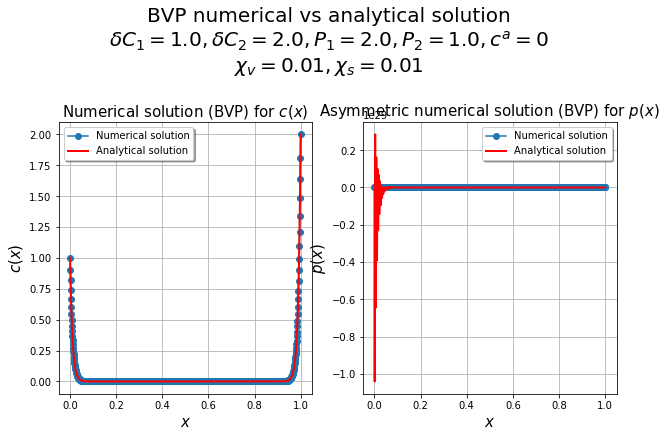

In [15]:
plot_cleft_sol_asymmetric(chis=1e-2, chiv=1e-2, dC1=1., dC2=2., P1=2., P2=1., ca=0)

# Symmetric case
## Concentration

**Equation** :
$$\chi_s^2 c''(x) - c(x) + c^a = 0$$

**Boundary conditions** :
$$c(-\frac{1}{2}) = \delta C_1, c(\frac{1}{2}) = \delta C_2$$

**Parameters** : $\chi_s$ and $c^a$



In [16]:
# Real function

def c_analytical_symmetric(x, chis, C1, C2, ca=0) :
    c1 = (C1 - ca) * np.sinh((x-0.5)/chis) / np.sinh(1./chis)
    c2 = (C2 - ca) * np.sinh((x+0.5)/chis) / np.sinh(1./chis)
    return ca - c1 + c2



In [17]:
# Boundary conditions
dC1, dC2 = 1., 2.

# Parameters
chis, ca = 1., 0.

In [18]:
def fun_concentration_symmetric(x, c) :
    global chis, ca
    return np.vstack((c[1], (c[0]-ca)/chis**2))

def bc_concentration_symmetric(ca, cb) :
    return np.array([ca[0]-dC1, cb[0]-dC2])

In [19]:
x_plot = np.linspace(-0.5, 0.5, 20)
c = np.ones((2, x_plot.size))
c[0, 0] = dC1
c[0, -1] = dC2


   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          7.75e-07       2.22e-16          20              0       
Solved in 1 iterations, number of nodes 20. 
Maximum relative residual: 7.75e-07 
Maximum boundary residual: 2.22e-16


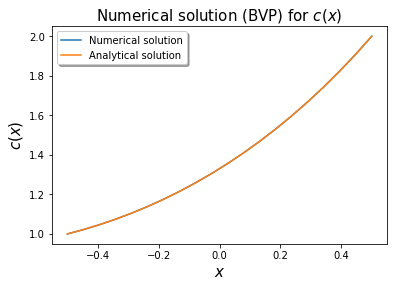

In [20]:
sol = solve_bvp(fun_concentration_symmetric, bc_concentration_symmetric, x_plot, c, verbose=2, max_nodes=7000)

c_plot = sol.sol(x_plot)[0]
dc_plot = sol.sol(x_plot)[1]


plt.title(r'Numerical solution (BVP) for $c(x)$', fontsize=15)
plt.plot(x_plot, c_plot, label='Numerical solution')

plt.plot(x_plot, c_analytical_symmetric(x_plot, chis, dC1, dC2, ca), label = 'Analytical solution')
plt.legend(shadow=True)
plt.xlabel(r'$x$', fontsize=15)
plt.ylabel(r'$c(x)$', fontsize=15)
plt.show()

## Pressure

**Equation**

$$\begin{cases}p''(x) &= \frac{1}{\chi_v^2} \left[p(x) - c(x)\right] \\
c''(x) &= \frac{1}{\chi_s^2} \left[ c(x) - c^a \right] \end{cases}$$

**Boundary Conditions**
$$c(-\frac{1}{2}) = \delta C_1, c(\frac{1}{2}) = \delta C_2$$
$$p(-\frac{1}{2}) = P_1, p(\frac{1}{2}) = P_2$$

**Parameters :** $\chi_v$, $\chi_s$, $c^a$



In [21]:
def p_analytical_symmetric(x, chiv, P1, P2, chis, dC1, dC2, ca=0) :
    
    p1 = P1 * np.sinh((x-0.5)/chiv) / np.sinh(1./chiv)
    p2 = P2 * np.sinh((x+0.5)/chiv) / np.sinh(1./chiv)
    
    lambda_x = lam_symmetric(x, chiv, chis, dC1, dC2, ca) * np.exp(x / chiv)
    mu_x = mu_symmetric(x, chiv, chis, dC1, dC2, ca) * np.exp(-x / chiv)
    
    lambda_a = np.exp(-0.5/chiv)*lam_symmetric(-0.5, chiv, chis, dC1, dC2, ca) * np.sinh((x-0.5)/chiv) / np.sinh(1./chiv)
    mu_b = np.exp(-0.5/chiv)*mu_symmetric(0.5, chiv, chis, dC1, dC2, ca) * np.sinh((x+0.5)/chiv) / np.sinh(1./chiv)
    
    #return - p1 + p2 + lambda_x + mu_x - lambda_a + mu_b
    return - p1 + p2 + lambda_x + mu_x + lambda_a - mu_b

# ======  Version 2

def I_1_minus_symmetric(x, Xv, Xs) :
    # for lam
    c1, s1 = np.cosh(1./Xs), np.sinh(1./Xs)
    cmx, smx = np.cosh((x-0.5)/Xs), np.sinh((x-0.5)/Xs)
    
    if Xv == Xs :
        return 0.5*( (x-0.5)*np.exp(-0.5/Xv) + 0.5*Xv*(np.exp(-2.*x/Xv) - np.exp(-1./Xv))*np.exp(0.5/Xv) )
    
    return Xv*Xs*(np.exp(-x/Xv)*(Xv*cmx + Xs*smx) - Xv*np.exp(-0.5/Xv))/ ( (Xv-Xs)*(Xv+Xs) )

def I_2_minus_symmetric(x, Xv, Xs) :
    # for lam
    c1, s1 = np.cosh(1./Xs), np.sinh(1./Xs)
    cpx, spx = np.cosh((x+0.5)/Xs), np.sinh((x+0.5)/Xs)
    
    if Xv == Xs :
        return 0.5*( (x-0.5)*np.exp(0.5/Xv) + 0.5*Xv*(np.exp(-2.*x/Xv) - np.exp(-1./Xv))*np.exp(-0.5/Xv) )
    
    return Xv*Xs*(np.exp(-x/Xv)*(Xv*cpx + Xs*spx) - np.exp(-0.5/Xv)*(Xv*c1 + Xs*s1))/ ( (Xv-Xs)*(Xv+Xs) )

def I_1_plus_symmetric(x, Xv, Xs) :
    # for mu
    c1, s1 = np.cosh(1./Xs), np.sinh(1./Xs)
    cmx, smx = np.cosh((x-0.5)/Xs), np.sinh((x-0.5)/Xs)
    
    if Xv == Xs :
        return 0.5*( 0.5*Xv*(np.exp(2.*x/Xv) - np.exp(-1./Xv))*np.exp(-0.5/Xv) - (x+0.5)*np.exp(0.5/Xv))
    
    return Xv*Xs*(np.exp(x/Xv)*(Xv*cmx - Xs*smx) - np.exp(-0.5/Xv)*(Xv*c1 + Xs*s1))/ ( (Xv-Xs)*(Xv+Xs) )

def I_2_plus_symmetric(x, Xv, Xs) :
    # for mu
    c1, s1 = np.cosh(1./Xs), np.sinh(1./Xs)
    cpx, spx = np.cosh((x+0.5)/Xs), np.sinh((x+0.5)/Xs)
    
    if Xv == Xs :
        return 0.5*( 0.5*Xv*(np.exp(2.*x/Xv) - np.exp(-1./Xv))*np.exp(0.5/Xv) - (x+0.5)*np.exp(-0.5/Xv))
    
    return Xv*Xs*(np.exp(x/Xv)*(Xv*cpx - Xs*spx) - np.exp(-0.5/Xv)*Xv)/ ( (Xv-Xs)*(Xv+Xs) )

def lam_symmetric(x, Xv, Xs, dC1, dC2, ca=0) :
    la = 0.5*ca * (np.exp(-x/Xv) - np.exp(-0.5/Xv))
    l1 = (dC1-ca) * I_1_minus_symmetric(x, Xv, Xs) / (2.*Xv*np.sinh(1./Xs))
    l2 = (dC2-ca) * I_2_minus_symmetric(x, Xv, Xs) / (2.*Xv*np.sinh(1./Xs))
    return la + l1 - l2

def mu_symmetric(x, Xv, Xs, dC1, dC2, ca=0) :
    ma = 0.5*ca * (np.exp(x/Xv) - np.exp(-0.5/Xv))
    m1 = (dC1-ca) * I_1_plus_symmetric(x, Xv, Xs) / (2.*Xv*np.sinh(1./Xs))
    m2 = (dC2-ca) * I_2_plus_symmetric(x, Xv, Xs) / (2.*Xv*np.sinh(1./Xs))
    return ma - m1 + m2


In [22]:
def plot_cleft_sol_symmetric(chis, chiv, dC1, dC2, P1, P2, ca, save=False, savename='BVP_solutions.eps') :
    # y[0, :] = c(x) ; y[1, :] = c'(x) ; y[2, :] = p(x) ; y[3, :] = p'(x)
    def fun_syst_in_symmetric(x, y) :
        # d y[0] /dx = c'
        # d y[1] /dx = (c - c^a) / \chi_s^2
        # d y[2] /dx = p'
        # d y[3] /dx = (p - c) / \chi_v^2
        return np.vstack((y[1], (y[0]-ca)/chis**2, y[3], (y[2]-y[0])/chiv**2))

    def bc_syst_in_symmetric(ya, yb) :
        # c(-1/2) = dC1 = ya[0]
        # c(+1/2) = dC2 = yb[0]
        # p(-1/2) = P1  = ya[2]
        # p(+1/2) = P2  = yb[2]
        return np.array([ya[0]-dC1, yb[0]-dC2, ya[2]-P1, yb[2]-P2 ])

    x = np.linspace(-0.5, 0.5, 10)
    y = np.zeros((4, x.size))

    y[0, 0], y[0, -1] = dC1, dC2
    y[2, 0], y[2, -1] = P1, P2
    
    sol = solve_bvp(fun_syst_in_symmetric, bc_syst_in_symmetric, x, y, verbose=2, max_nodes=10000)
    
    x_plot = np.linspace(-0.5, 0.5, 101)
    c_plot = sol.sol(x_plot)[0]
    p_plot = sol.sol(x_plot)[2]

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))
    my_suptitle=  fig.suptitle('BVP numerical vs analytical solution\n$\delta C_1='+str(dC1)+', \delta C_2='+str(dC2)+', P_1='+str(P1)+', P_2='+str(P2)+', c^a='+str(ca)+'$\n$\chi_v='+str(chiv)+', \chi_s='+str(chis)+'$', y=1.2, fontsize=20)

    ax[0].set_title(r'Numerical solution (BVP) for $c(x)$', fontsize=15)
    ax[0].plot(x_plot, c_plot, label='Numerical solution', color = 'C0', marker='o')
    ax[0].plot(x_plot, c_analytical_symmetric(x_plot, chis, dC1, dC2, ca), label = 'Analytical solution', linewidth=2, color = 'r')
    ax[0].legend(shadow=True)
    ax[0].set_xlabel(r'$x$', fontsize=15)
    ax[0].set_ylabel(r'$c(x)$', fontsize=15)
    ax[0].grid()

    ax[1].set_title(r'Symmetric numerical solution (BVP) for $p(x)$', fontsize=15)
    ax[1].plot(x_plot, p_plot, label='Numerical solution', color =  'C0', marker='o')
    ax[1].plot(x_plot, p_analytical_symmetric(x_plot, chiv, P1, P2, chis, dC1, dC2, ca), label = 'Analytical solution', linewidth=2, color = 'r')
    ax[1].legend(shadow=True)
    ax[1].set_xlabel(r'$x$', fontsize=15)
    ax[1].set_ylabel(r'$p(x)$', fontsize=15 )
    ax[1].grid()
    if save :
        plt.savefig(savename, format='eps', bbox_inches='tight',bbox_extra_artists=[my_suptitle])
    plt.show()

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.25e-02       8.88e-16          10              9       
       2          1.41e-03       1.61e-18          19             10       
       3          1.00e-03       1.61e-19          29              0       
Solved in 3 iterations, number of nodes 29. 
Maximum relative residual: 1.00e-03 
Maximum boundary residual: 1.61e-19


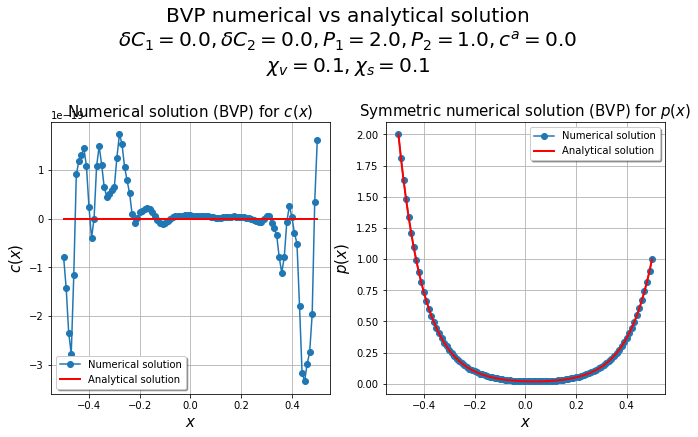

In [23]:
plot_cleft_sol_symmetric(chis=1e-1, chiv=1e-1, dC1=0., dC2=0., P1=2., P2=1., ca=0., save=0, savename='BVP_solutions_3.eps')



# Chain pressure profile

In [24]:
module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path :
    sys.path.append(module_path)
import _ressources.lumenclass as lc
import _ressources.tools as tools

In [25]:
def calc_iflumenbridge(x, chain) :
    """
    Returns True if x is in a lumen (with the index of the lumen)
    Returns False if x is in a bridge (with the index of the bridge)
    """ 
    pos_dict = {k : chain.lumens_dict[k].pos for k in chain.lumens_dict.keys()}
    length_dict = {k : chain.lumens_dict[k].length for k in chain.lumens_dict.keys()}
    lum_dict = {k : [pos_dict[k]-length_dict[k], pos_dict[k]+length_dict[k]] for k in chain.lumens_dict.keys()}
    
    b_dict = {b : [chain.bridges_dict[b].lumen1, chain.bridges_dict[b].lumen2] for b in chain.bridges_dict.keys()}
    
    for k in lum_dict.keys() :
        if x >= lum_dict[k][0] and x <= lum_dict[k][1] :
            return True, k
        
    for b in b_dict.keys() :
        lum1 = b_dict[b][0]
        lum2 = b_dict[b][1]
        if x > lum_dict[lum1][1] and x < lum_dict[lum2][0] :
            return False, b
        

In [81]:
def lumen_pressure(index, chain) :
    if index != 0 and index != -1 :
        L0 = chain.total_length
        Lj = chain.lumens_dict[index].length
        eps_j = chain.lumens_dict[index].eps
        return L0*eps_j/Lj
    else :
        return 0.
    
def lumen_concentration(index, chain) :
    if index != 0 and index != -1 :
        Lj = chain.lumens_dict[index].length
        Nj = chain.lumens_dict[index].nb_ions
        mu_j = chain.lumens_dict[index].mu
        return mu_j * Nj / (Lj*Lj) - 1.
    else :
        return 0.

def calc_local_pressure(x, chain) :
    pressure_x = np.zeros(len(x))
    
    
    for i in range(len(x)) :    
        lum, index = calc_iflumenbridge(x[i], chain)
        
        if lum :
            pressure_x[i] = lumen_pressure(index, chain)
            
        else :
            lum1, lum2 = chain.bridges_dict[index].lumen1, chain.bridges_dict[index].lumen2
            
            lum1_x = chain.lumens_dict[lum1].pos + chain.lumens_dict[lum1].length
            lum2_x = chain.lumens_dict[lum2].pos - chain.lumens_dict[lum2].length
            xmiddle = 0.5*(lum2_x + lum1_x)
            ell = lum2_x - lum1_x
            xp = (x[i] - xmiddle)/ell
            
            P1 = lumen_pressure(lum1, chain)
            P2 = lumen_pressure(lum2, chain)
            C1 = lumen_concentration(lum1, chain)
            C2 = lumen_concentration(lum2, chain)
            #print(C1, C2)
            ca = chain.bridges_dict[index].ca
            
            chiv = chain.xiv / ell
            chis = chain.xis / ell
            
            #print(index, lum1, lum2, xp, P1, P2, C1, C2, ca)
            
            pressure_x[i] = p_analytical_symmetric(xp, chiv, P1, P2, chis, C1, C2, ca)
            
    return pressure_x

def calc_local_concentration(x, chain) :
    concentration_x = np.zeros(len(x))
    
    
    for i in range(len(x)) :    
        lum, index = calc_iflumenbridge(x[i], chain)
        
        if lum :
            concentration_x[i] = lumen_concentration(index, chain)
            
        else :
            lum1, lum2 = chain.bridges_dict[index].lumen1, chain.bridges_dict[index].lumen2
            
            lum1_x = chain.lumens_dict[lum1].pos + chain.lumens_dict[lum1].length
            lum2_x = chain.lumens_dict[lum2].pos - chain.lumens_dict[lum2].length
            xmiddle = 0.5*(lum2_x + lum1_x)
            ell = lum2_x - lum1_x
            xp = (x[i] - xmiddle)/ell
            
            C1 = lumen_concentration(lum1, chain)
            C2 = lumen_concentration(lum2, chain)
            #print(C1, C2)
            ca = chain.bridges_dict[index].ca
            
            chiv = chain.xiv / ell
            chis = chain.xis / ell
            
            #print(index, lum1, lum2, xp, P1, P2, C1, C2, ca)
            
            concentration_x[i] = c_analytical_symmetric(xp, chis, C1, C2, ca)
            
    return concentration_x
            

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


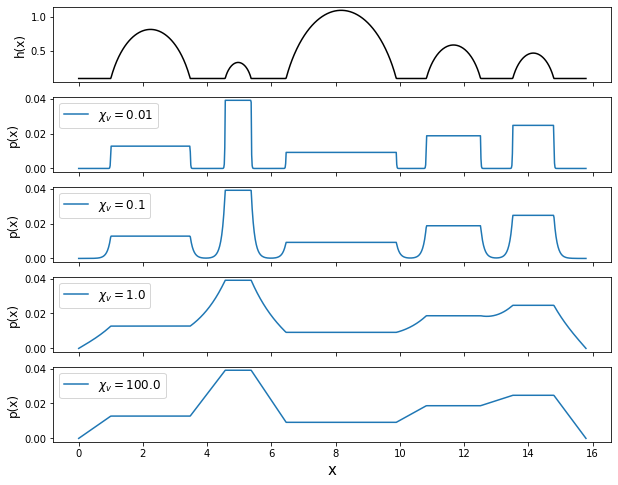

In [100]:
np.random.seed(1234)

ell0 = 1.
chis, chiv = 1., 100.

nb_lumens = 5

chain = lc.Osmotic_Chain(nb_lumens)
chain.__gen_network_lumen_object__(avg_size=1., std_size=0.5, avg_dist = ell0, std_dist=0.1, dist_toleft=1, dist_toright=1, ca_lumen_list=[], ca_bridge_list=[], equilibrium=True)

set_equilibrium = True
if set_equilibrium :
    for k in range(1, nb_lumens+1) :
        chain.lumens_dict[k].nb_ions = chain.lumens_dict[k].length**2/chain.lumens_dict[k].mu

chi_list = [(1., 0.01), (1., .1), (1., 1.),  (1., 100.)]

x = np.linspace(0., chain.total_length, 1001)

fig, ax = plt.subplots(len(chi_list)+1, 1, figsize=(10, 8), sharex=True)
ax[0].plot(x, tools.profile(x, chain)[0], color='k')
#ax[0].axis('equal')
ax[0].set_ylabel('h(x)', fontsize=12)

i=1
for elem in chi_list :
    chis = elem[0]
    chiv = elem[1]
    chain.xis, chain.xiv = ell0*chis, ell0*chiv
    p = calc_local_pressure(x, chain)
    ax[i].plot(x, p, label = r'$\chi_v = $' + str(chiv))
    ax[i].set_ylabel('p(x)', fontsize=12)
    ax[i].legend(fontsize=12, loc=2)
    i+=1
ax[i-1].set_xlabel('x', fontsize=15)
plt.savefig('/Users/mathieuleverge/git/chain_lumen/_notebook/figures/pressure_profile_chain.eps', format='eps')
plt.show()